In [30]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics


In [31]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\seqFISH\filtered_seqFish.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1.obs['annotation'] = adata_1.obs['celltype_mapped_refined']
adata_1


AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped', 'annotation'
    var: 'gene_names'
    obsm: 'spatial'

In [32]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Stereo_seq\filtered_Stereoseq.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [33]:
Cal_Spatial_Net(adata_1, k_cutoff=50, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=25, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 642647 edges, 11529 cells.
55.741781594240614 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 132251 edges, 5031 cells.
26.287219240707614 neighbors per cell on average.


In [34]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actu

In [35]:
adata_1.obsm['X_dpca'] = features[0].numpy()
adata_2.obsm['X_dpca'] = features[1].numpy()

In [36]:
adata_1

AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped', 'annotation'
    var: 'gene_names'
    uns: 'Spatial_Net'
    obsm: 'spatial', 'X_dpca'

In [37]:
adata_2

AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [38]:
adata_1.write('./seqFISH_filter.h5ad')
adata_2.write('./Stereo_seq_filter.h5ad')

In [39]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 57.83


In [40]:
adata_1.obsm['scSLAT'] = embd2.detach().cpu().numpy()
adata_2.obsm['scSLAT'] = embd3.detach().cpu().numpy()

adata_com_2 = sc.concat([adata_1,adata_2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
adata_com_2

AnnData object with n_obs × n_vars = 16560 × 347
    obs: 'annotation', 'slice_name'
    uns: 'neighbors', 'umap', 'slice_name_colors', 'annotation_colors'
    obsm: 'spatial', 'X_dpca', 'scSLAT', 'X_umap'
    obsp: 'distances', 'connectivities'

In [46]:
adata_com_2.write('./SLAT_embd.h5ad')

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


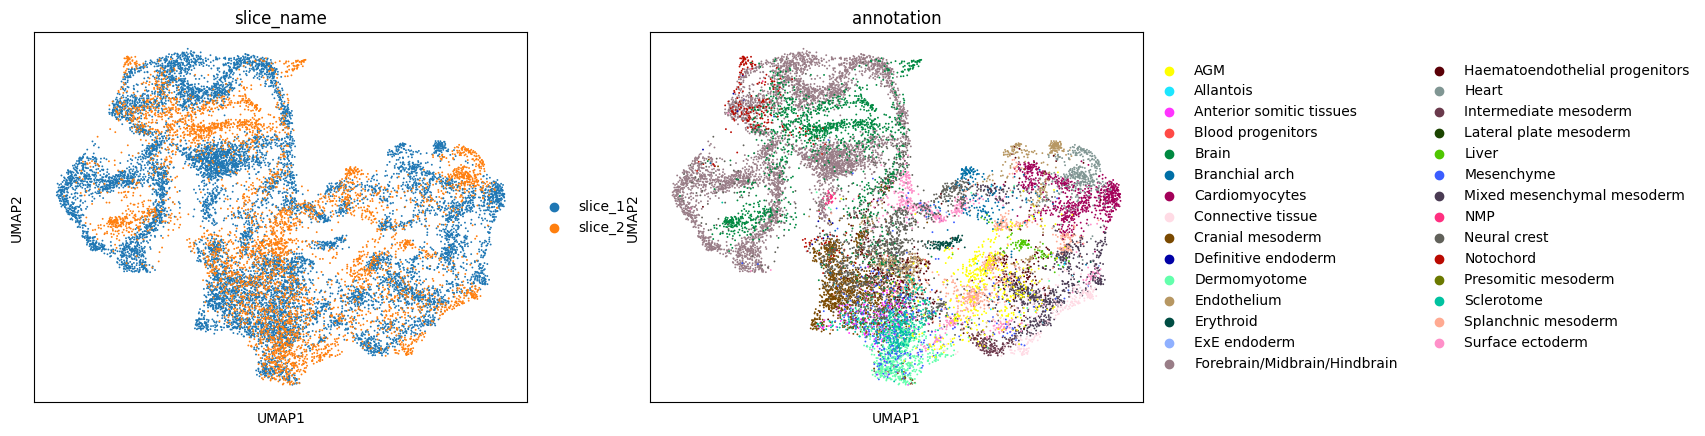

In [41]:
sc.pl.umap(adata_com_2, color= ['slice_name', 'annotation'])

In [43]:
best_2, index_2, distance_2 = spatial_match([embd2, embd3], adatas=[adata_1, adata_2], reorder=False)
adata3_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata4_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_2 = np.array([range(index_2.shape[0]), best_2])
best_match_2 = distance_2[:,0]

dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Erythroid', 'Lateral plate mesoderm', 'ExE endoderm', 'Intermediate mesoderm', 'Splanchnic mesoderm', 'Haematoendothelial progenitors', 'Definitive endoderm', 'Forebrain/Midbrain/Hindbrain', 'Surface ectoderm', 'Cardiomyocytes', 'Allantois', 'Endothelium', 'Anterior somitic tissues', 'Presomitic mesoderm', 'Cranial mesoderm', 'NMP', 'Mixed mesenchymal mesoderm', 'Blood progenitors', 'Connective tissue', 'Notochord', 'Heart', 'Mesenchyme', 'Brain', 'Branchial arch', 'AGM', 'Liver']]
Subsampled 300 pairs from 5031


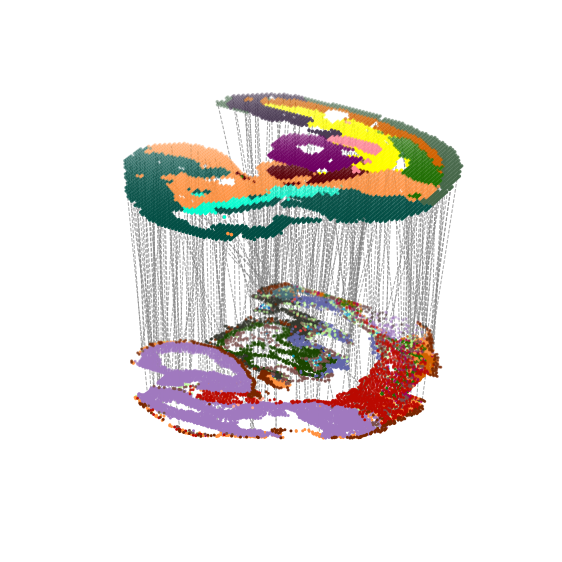

In [44]:
multi_align_2 = match_3D_multi(adata3_df, adata4_df, matching_2, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align_2.draw_3D(size=[7, 8], line_width=0.7, line_color='grey', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False, save='./Alignment_2.png')

In [49]:
adata_3=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\seqFISH_filter.h5ad")
adata_3.var_names_make_unique(join="++")
adata_3.obs['annotation']

embryo2_Pos29_cell10_z2       Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell10_z5       Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z2      Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z5      Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell101_z5      Forebrain/Midbrain/Hindbrain
                                         ...              
embryo2_Pos50_cell83_z2     Haematoendothelial progenitors
embryo2_Pos50_cell83_z5       Forebrain/Midbrain/Hindbrain
embryo2_Pos50_cell84_z2                Splanchnic mesoderm
embryo2_Pos50_cell86_z5       Forebrain/Midbrain/Hindbrain
embryo2_Pos50_cell92_z2       Forebrain/Midbrain/Hindbrain
Name: annotation, Length: 11529, dtype: category
Categories (21, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Presomitic mesoderm', 'Sclerotome', 'Splanchnic mesoderm', 'Surface ectoderm']

In [50]:
adata_4=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\Stereo_seq_filter.h5ad")
adata_4.var_names_make_unique(join="++")
adata_4.obs['annotation']

cell_name
147_108    Mesenchyme
147_109    Mesenchyme
147_110    Mesenchyme
147_111    Mesenchyme
147_112    Mesenchyme
              ...    
252_112         Brain
252_113         Brain
252_114         Brain
252_115         Brain
252_116         Brain
Name: annotation, Length: 5031, dtype: category
Categories (11, object): ['AGM', 'Brain', 'Branchial arch', 'Connective tissue', ..., 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']